
# Riemann problem for acoustics

This notebook illustrates some features of the exact solution to the 1-dimensional constant coefficient acoustics equations.

The notebook can be found in the clawpack apps respository:  

- `$CLAW/apps/notebooks/riemann/Riemann_problem_acoustics.ipynb`
- See http://www.clawpack.org/apps.html.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The next cell imports a module containing a function that takes a Riemann problem (left state, right state, and approximate solver), and computes the Riemann solution, as well as functions to plot the solution in various forms.  

In [3]:
#from clawpack.riemann import riemann_tools

# the version from clawpack.riemann needs updating, 
# for active development use the version in this repository instead:
import sys
sys.path.insert(0,'..')  
import riemann_tools

# Acoustics: exact solution
We can use this to examine the exact solution of an acoustics Riemann problem.

This is a linear hyperbolic system of two equations for $q = [p, u]^T$, where $p$ is the pressure perturbation and $u$ is the velocity.  The system is $q_t + Aq_x = 0$, where the coefficient matrix is

$$
A = \left[\begin{array}{cc}0&K\\1/\rho&0\end{array}\right], 
$$

where $\rho$ is the density and $K$ the bulk modulus.  If we define the sound speed $c = \sqrt{K/\rho}$ and impedance $Z=\sqrt{K\rho}$, then the eigenvalues of the matrix are $s^1 = -c$ and $s^2 = +c$ and the corresponding eigenvectors are
$$
r^1 = \left[\begin{array}{c}-Z\\1\end{array}\right], \qquad r^2 = \left[\begin{array}{c}Z\\1\end{array}\right].
$$

For arbitrary states $q_\ell$ and $q_r$, the Riemann solution consists of two waves propagating with velocities $\pm c$ with an intermediate state $q_m$ that is connected to $q_\ell$ by a multiple of $r^1$ and to $q_r$ by a multiple of $r^2$.

This Riemann solver can be solved by the PyClaw solver `riemann.acoustics_1D_py.acoustics_1D`:

In [4]:
from clawpack.riemann.acoustics_1D_py import acoustics_1D
solver = acoustics_1D

### Set some problem data needed by the solver:

In [5]:
problem_data = {}

rho = 1.            # density
K = 4.              # bulk modulus
c = np.sqrt(K/rho)  # sound speed
Z = np.sqrt(K*rho)  # impedance

print("Density rho = %g, Bulk modulus K = %g" % (rho,K))
print("Sound speed = %g, Impedance = %g" % (c,Z))

problem_data['zz'] = Z 
problem_data['cc'] = c

Density rho = 1, Bulk modulus K = 4
Sound speed = 2, Impedance = 2


### Set the left and right states, and solve the Riemann problem

In [6]:
q_l = np.array((1,4))  # Left state
q_r = np.array((3,7))  # Right state

states, s, riemann_eval = riemann_tools.riemann_solution(solver,q_l,q_r,\
                                            problem_data=problem_data, verbose=True)

States in Riemann solution:


⎡⎡1.0⎤, ⎡-1.0⎤, ⎡3.0⎤⎤
⎢⎢   ⎥  ⎢    ⎥  ⎢   ⎥⎥
⎣⎣4.0⎦  ⎣5.0 ⎦  ⎣7.0⎦⎦

Waves (jumps between states):


⎡⎡-2.0⎤, ⎡4.0⎤⎤
⎢⎢    ⎥  ⎢   ⎥⎥
⎣⎣1.0 ⎦  ⎣2.0⎦⎦

Speeds: 


[-2.0  2.0]

Fluctuations amdq, apdq: 


[[4.0  -2.0], [8.0  4.0]]

### Plot the states in the phase plane:

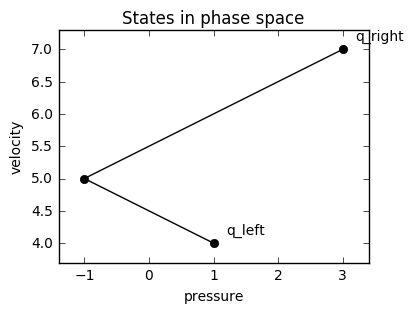

In [7]:
fig = plt.figure(figsize=(4,3))
ax = plt.axes()
riemann_tools.plot_phase(states, ax=ax, label_h='pressure', label_v='velocity')

### Plot the waves in the x-t plane, and the solution at one particular time:

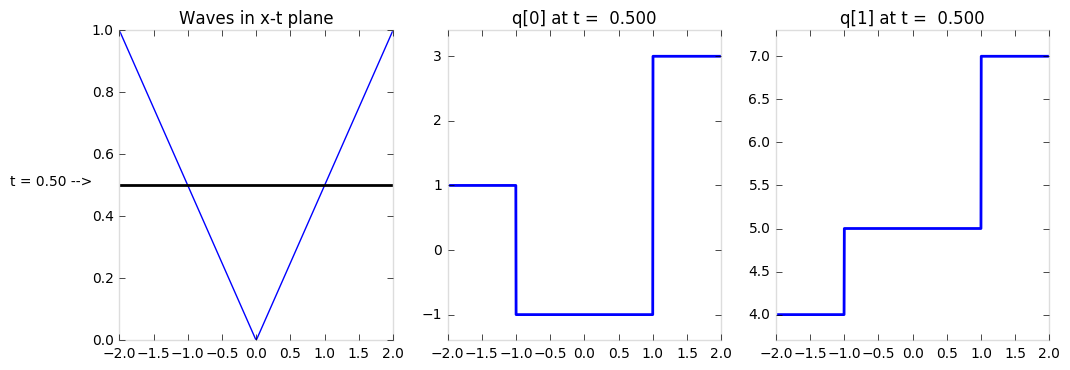

In [8]:
fig = riemann_tools.plot_riemann(states,s,riemann_eval,t=0.5)

### Animate the Riemann solution:

In [9]:
riemann_tools.JSAnimate_plot_riemann(states,s,riemann_eval)

## Shock tube problem:

If the velocity is 0 in both initial states (the shock tube problem) then the resulting Riemann solution consists of pressure jumps of equal magnitude propagating in each direction, with equal and opposite jumps in velocity.

States in Riemann solution:


⎡⎡5.0⎤, ⎡3.0⎤, ⎡1.0⎤⎤
⎢⎢   ⎥  ⎢   ⎥  ⎢   ⎥⎥
⎣⎣0.0⎦  ⎣1.0⎦  ⎣0.0⎦⎦

Waves (jumps between states):


⎡⎡-2.0⎤, ⎡-2.0⎤⎤
⎢⎢    ⎥  ⎢    ⎥⎥
⎣⎣1.0 ⎦  ⎣-1.0⎦⎦

Speeds: 


[-2.0  2.0]

Fluctuations amdq, apdq: 


[[4.0  -2.0], [-4.0  -2.0]]

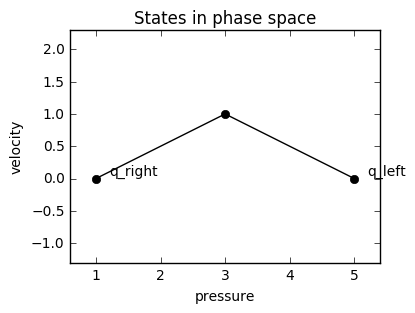

In [10]:
q_l = np.array((5,0))  # Left state
q_r = np.array((1,0))  # Right state

states, s, riemann_eval = riemann_tools.riemann_solution(solver,q_l,q_r,\
                                        problem_data=problem_data, verbose=True)

fig = plt.figure(figsize=(4,3))
ax = plt.axes()
riemann_tools.plot_phase(states, ax=ax, label_h='pressure', label_v='velocity')

In [11]:
riemann_tools.JSAnimate_plot_riemann(states,s,riemann_eval)

### Plot the particle trajectories

For the acoustics equations, the second component of `q` is the velocity.  By integrating the velocities we can get particle positions.  The following utility function does this for us based on the Riemann solution, solving

$$
X'(t) = u(X(t), t),\qquad \text{for} \quad t \geq 0, \qquad \text{with initial data} ~ X(0) = x_0
$$

for a set of 20 initial particle locations $x_0$ evenly distributed along the x-axis at time $=0$.

Note that the particles initially have velocity 0 and are accelerated to the right by either acoustic wave.  The velocity is constant between the two waves and positive because the pressure chosen was greater to be greater in the left state than in the right state.  If $p_\ell < p_r$ the the fluid would be accelerated to the left instead.

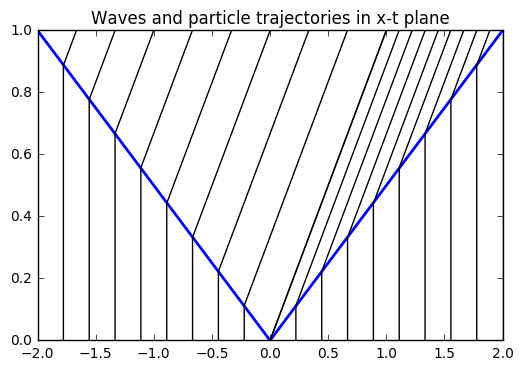

In [12]:
riemann_tools.plot_riemann_trajectories(states,s,riemann_eval,i_vel=1)

## Flow into a wall:

As another example, suppose the pressure is initially the same in the left and right states, while the velocities are non-zero with $u_r = -u_\ell > 0$.  Particles are converging from both sides and if the initial states have this symmetry, then the result is a middle state $q_m$ in which the velocity is 0 (and the pressure is higher than on either side).

States in Riemann solution:


⎡⎡3.0⎤, ⎡7.0⎤, ⎡3.0 ⎤⎤
⎢⎢   ⎥  ⎢   ⎥  ⎢    ⎥⎥
⎣⎣2.0⎦  ⎣0.0⎦  ⎣-2.0⎦⎦

Waves (jumps between states):


⎡⎡4.0 ⎤, ⎡-4.0⎤⎤
⎢⎢    ⎥  ⎢    ⎥⎥
⎣⎣-2.0⎦  ⎣-2.0⎦⎦

Speeds: 


[-2.0  2.0]

Fluctuations amdq, apdq: 


[[-8.0  4.0], [-8.0  -4.0]]

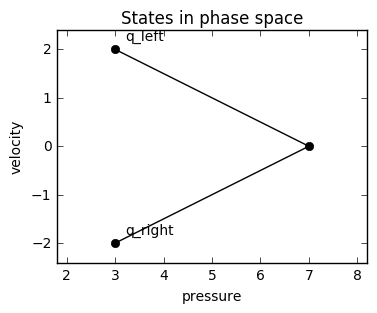

In [13]:
q_l = np.array((3,2))  # Left state
q_r = np.array((3,-2))  # Right state

states, s, riemann_eval = riemann_tools.riemann_solution(solver,q_l,q_r,\
                                        problem_data=problem_data, verbose=True)

fig = plt.figure(figsize=(4,3))
ax = plt.axes()
riemann_tools.plot_phase(states, ax=ax, label_h='pressure', label_v='velocity')

In [14]:
riemann_tools.JSAnimate_plot_riemann(states,s,riemann_eval)

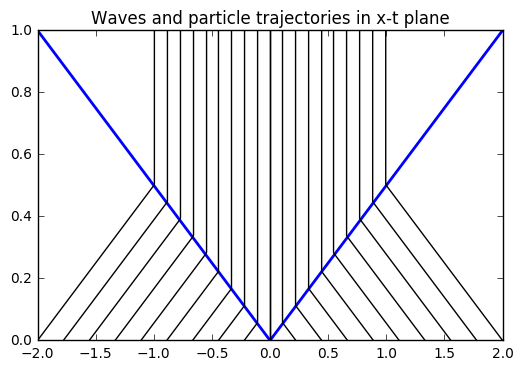

In [15]:
riemann_tools.plot_riemann_trajectories(states,s,riemann_eval,i_vel=1)

If you discard half the solution (for $x>0$ or for $x<0$) then what you see can be viewed as the solution to a problem with fluid streaming at constant velocity toward a solid wall.  The result is an acoustic wave that moves away from the wall, and the fluid behind the shock has been decelerated to velocity 0, i.e. it is stationary at the wall.

This type of Riemann solution is critical when imposing solid wall boundary conditions in a numerical method. If ghost cells are introduced outside the domain and the state in the ghost cell set by reflecting the interior solution with the symmetry seen here (equal pressure, negated velocity), then the solution to the Riemann problem at the cell interfaces yields a solution that satisfies the desired boundary conditions. 